# Resume Scorer
8/02/2026
By Yanni Karlaftis (Github: Cactus878)

#### Libraries

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import OrdinalEncoder
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import pandas as pd
import pdfplumber
import numpy as np
import joblib
import math
import re
import torch
import seaborn as sns

#### Resume and Job Listing to Compare

In [5]:
#resume = "business-marketing-resume-example.pdf"
resume = "Resume.pdf"
#resume = "it-resume-example.pdf"
#resume = "professional-it-resume-example.pdf"

In [6]:
job_listing = """
Full job description
Are you a Data professional who has recently transitioned into Data Modelling??
Your new company
A leading Victorian State Government entity dedicated to protecting the people, places, and projects that enable the community to thrive is seeking a Junior Data Modeller for an initial 6‑month contract.This organisation plays a critical role in risk management and public-sector resilience and is continuing to strengthen its data capability to support strategic, analytic, and operational outcomes.

Your new role
As the Junior Data Modeller, you will support data and digital initiatives by assisting in mapping how front‑end systems relate to underlying data structures. Your contributions will enhance data quality, improve reporting accuracy, and support enterprise data modelling efforts. Key responsibilities include:

Analyse front‑end systems and workflows to understand how fields map to backend databases.
Contribute to logical and conceptual data models describing entities, relationships, and key business rules.
Support alignment of application‑level data structures with enterprise data models and reporting requirements.
Develop and maintain documentation such as data dictionaries, mapping documents, metadata records, and simple ER‑style diagrams.
Capture and update data lineage, ownership information, and metadata in agreed repositories.
Assist with data profiling activities to validate mappings and ensure data quality.
Support testing of integrations and reporting outputs to ensure fields and relationships populate correctly.
Identify basic data issues or inconsistencies and escalate them for remediation.
Contribute to compliance, governance, and risk processes by following controls and reporting risks where needed.
Maintain version control of documentation and promote consistency across artefacts.

What you'll need to succeed
To thrive in this role, you will bring technical curiosity, strong attention to detail, and a passion for understanding how systems and data fit together. Essential skills & experience:
Exposure to relational databases and SQL through study, projects, internships, or early work experience.
Bachelor degree in Data Science.
Basic understanding of how front‑end applications interact with back‑end databases or APIs.
Strong analytical and problem‑solving skills, with the ability to break down ambiguous problems.
Clear written communication skills and a detail‑oriented approach to documentation.
Demonstrated interest in systems, data structures, and end‑to‑end data flows.
Data analysis, Data engineering, Data modelling experience
Exposure in business intelligence or reporting & software development
Familiarity with data modelling concepts (entities, relationships, normalisation, dimensional models)
Reporting/visualisation tools (e.g., Power BI)
At least 2 years of experience

What you'll get in return
A valuable opportunity to gain hands‑on experience in an enterprise‑level data environment within the public sector.
Exposure to senior data professionals and a supportive, collaborative team culture.
The chance to develop your skills in data modelling, documentation, analytics, and systems mapping.
A meaningful role contributing to public safety, resilience, and community outcomes.
Competitive daily rate and hybrid working flexibility.

What you need to do now
If you're interested in this role, click 'apply now' to forward an up-to-date copy of your CV to Prachi.Kalyanarora@Hays.com.au, or call us now.
If this job isn't quite right for you, but you are looking for a new position, please contact us for a confidential discussion on your career.
"""

#### Vectorize, Segmentate, and Chunk Resume

In [8]:
import spacy
##---Vectorize Model---##
nlp = spacy.load("en_core_web_lg")

W0216 18:43:12.415000 9400 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [9]:
##---Get Vector For Word---##
def word_to_vector(word: str) -> np.ndarray:
    token = nlp(word)
    if token.has_vector:
        return token.vector
    else:
        # fallback for unknown words
        return np.zeros(300)

In [10]:
##---Return Textual Information And Vectorize Words For Title Classification---##
def vectorize_resume(resume_dir: str, encoder: OrdinalEncoder()) -> (pd.DataFrame, list):
    resume_data = []
    with pdfplumber.open(f'{resume_dir}') as pdf:
        # Loop through each page
        for page in pdf.pages:
            # Store words in page
            words = page.extract_words(extra_attrs=["fontname", "size"])
            for w in words:
                # Store specific attributes from every word and char in the resume page
                resume_data.append({"word": w["text"],
                            "width": w["width"],
                            "height": w["height"],
                            "left_distance": w["x0"], 
                            "bottom_distance": w["bottom"], 
                            "right_distance": w["x1"], 
                            "top_distance": w["top"],
                            "fontname": w["fontname"],
                            "fontsize": w["size"]})
        # Store pages
        pages = pdf.pages

    # Transform dict to pandas dataframe
    resume_data = pd.DataFrame(resume_data)
    # Rename col
    resume_data['original_word'] = resume_data['word']
    # Add vector to single col for each word
    resume_data['word'] = resume_data['word'].apply(lambda x: word_to_vector(x))
    # Create matrix
    vector_matrix = np.vstack(resume_data['word'].values)
    # Turn matrix into a df
    vector_df = pd.DataFrame(vector_matrix, index=resume_data.index)
    # Rename col names
    vector_df.columns = [f"vec_{i}" for i in range(vector_df.shape[1])]
    # Remove word col
    meta_df = resume_data.drop(columns=['word'])
    # Concatenate data frames
    resume_data_vec = pd.concat([vector_df, meta_df], axis=1)

    # Encode fontnames into their respective numbers for classification
    resume_data_vec['fontname'] = encoder.transform(resume_data_vec['fontname'])
    return resume_data_vec, pages

In [11]:
def get_cluster_centers(df: pd.DataFrame, predicted: np.ndarray, original_words: pd.Series, show_cluster_centers: bool) -> (pd.DataFrame, dict):
    cluster_centers = {"EDUCATION": [], "EXPERIENCE": [], "SKILLS":[], "PERSONAL":[]}

    rows_to_drop = []
    for i, p in enumerate(predicted):
        if pd.notna(p):
            if show_cluster_centers == True:
                print(f'Cluster: {original_words[i]}')
            cluster_centers[p].append(((df.iloc[i]['left_distance'] + df.iloc[i]['right_distance']) / 2, 
                                       (df.iloc[i]['bottom_distance'] + df.iloc[i]['top_distance']) / 2))
            rows_to_drop.append(i)
            
    df.drop(index=rows_to_drop, inplace=True)
    
    return df, cluster_centers

In [12]:
def calculate_word_x_and_y_position(df: pd.DataFrame, left: pd.Series, right:pd.Series, up: pd.Series, down: pd.Series) -> pd.DataFrame:
    calculate_center_position = lambda a, b: (a + b) / 2
    
    df["X"] = calculate_center_position(left, right) 
    df["Y"] =  calculate_center_position(down, up) 
    
    return df

In [13]:
##---Combine close clusters to eachother of the same category---##
def combine_close_cluster_titles(clusters: dict, threshold: int=250) -> dict:
    new_cluster_centers = {"EDUCATION": [], "EXPERIENCE": [], "SKILLS":[], "PERSONAL":[], "UNKOWN":[]}
    
    clusters_to_skip = []
    for index, cluster_arr in clusters.items():
        # Check if more titles exist for this category
        if len(cluster_arr) > 1:
            for i in cluster_arr:
                closest_index_to_i_val = float('inf')
                closest_index_to_i_pos = None
                # Skip if i has already combined previously
                if i in clusters_to_skip:
                    continue
                else:
                    for j in cluster_arr:
                        # Prevent combining same cluster
                        if i == j:
                            continue
                        else:
                            # Calculate distance from title i and j
                            current_euclidean_distance = math.sqrt((i[0] - j[0])**2 + ((i[1] - j[1])*4.0)**2)
                            # Store results of closest title to title i
                            if current_euclidean_distance < closest_index_to_i_val:
                                closest_index_to_i_val = current_euclidean_distance
                                closest_index_to_i_pos = j
 
                if closest_index_to_i_val < threshold:
                    # Add new cluster 
                    new_cluster_centers[index].append(((i[0] + closest_index_to_i_pos[0]) / 2, (i[1] + closest_index_to_i_pos[1]) / 2))
                    # Prevent combining j in future loops
                    clusters_to_skip.append(closest_index_to_i_pos)
                else:
                    new_cluster_centers[index].append(i)
        else:
            new_cluster_centers[index] = cluster_arr
    return new_cluster_centers

In [14]:
def create_y_divider(df: pd.DataFrame, clusters: dict, detection_range: int=10):
    divider_y_position = 0.0
    valid_y_dividers = [float("inf"), 0.0]
    all_title_y_points = []
    
    for points in clusters.values():
        for point in points:
            all_title_y_points.append(point[1])
            if point[1] > divider_y_position:
                divider_y_position = point[1]

    while divider_y_position > 0:
        valid_position = True
        closest_word_dist = float("inf")

        # Get closest cluster to divider_y_position
        point = None
        closest_title_point_dist = float("inf")

        if len(all_title_y_points) <= 0:
            break
            
        for title_point in all_title_y_points:
            if closest_title_point_dist > abs(divider_y_position - title_point):
                closest_title_point_dist = abs(divider_y_position - title_point)
                point = title_point
            
        if point > divider_y_position:
            for _, word in df.iterrows():
                if word["Y"] >= (divider_y_position - detection_range) and word["Y"] <= (divider_y_position + detection_range):
                    valid_position = False
                    break
                if closest_word_dist > abs(divider_y_position - word["Y"]):
                    closest_word_dist = abs(divider_y_position - word["Y"])
        else:
            valid_position = False
                            
        if valid_position == True:
            if min(all_title_y_points) > divider_y_position:
                valid_position = False
        
        if valid_position == True:
            if closest_word_dist < closest_title_point_dist:
                valid_position = False
        
        if valid_position == True:
            valid_y_dividers.append(divider_y_position)
            all_title_y_points.remove(point)
        
        divider_y_position -= detection_range
        
    valid_y_dividers.sort(reverse=True)
    return valid_y_dividers

In [15]:
def create_x_divider(df: pd.DataFrame, clusters: dict, valid_y_dividers: list[float], detection_range: int=10):
    divider_x_position = 0.0
    valid_x_dividers = []
    all_title_x_points = []
    
    for points in clusters.values():
        for point in points:
            all_title_x_points.append(point)
            if point[0] > divider_x_position:
                divider_x_position = point[0]
                
    while divider_x_position > 0:
        valid_position = True
        closest_word_dist = float("inf")

        # Get closest cluster to divider_x_position
        point = None
        closest_title_point_dist = float("inf")

        if len(all_title_x_points) <= 0:
            break

        for i, _ in enumerate(valid_y_dividers):
            if i == len(valid_y_dividers) - 1:
                break;
            j = i + 1
            
            for title_point in all_title_x_points:
                x_dist_val = abs(divider_x_position - title_point[0])
                if closest_title_point_dist > x_dist_val and title_point[1] <= valid_y_dividers[i] and title_point[1] >= valid_y_dividers[j]:
                    closest_title_point_dist = x_dist_val
                    point = title_point

            if point == None:
                break;

            if divider_x_position > point[0]:
                for _, word in df.iterrows():
                    if word["Y"] <= valid_y_dividers[i] and word["Y"] >= valid_y_dividers[j]:
                        if word["X"] >= (divider_x_position - detection_range) and word["X"] <= (divider_x_position + detection_range):
                            valid_position = False
                            break
                        if closest_word_dist > abs(divider_x_position - word["X"]):
                            closest_word_dist = abs(divider_x_position - word["X"])
            else: 
                valid_position = False
                
            if valid_position == True:
                valid_title_x_points = [x[0] for x in all_title_x_points if x[0] <= valid_y_dividers[i] and x[0] >= valid_y_dividers[j]]
                if len(valid_title_x_points) > 0:
                    if min(valid_title_x_points) > divider_x_position:
                        valid_position = False
                else: 
                    valid_position = False

            #if valid_position == True:
                #if closest_word_dist < closest_title_point_dist:
                    #valid_position = False
            
            if valid_position == True:
                valid_x_dividers.append((divider_x_position, valid_y_dividers[i], valid_y_dividers[j]))
                all_title_x_points.remove(point)
                
        divider_x_position -= detection_range
    return valid_x_dividers

In [16]:
##---Cluster each word to their closest title by their y-axis and assigning it's id to respective word---##
def cluster_text(df: pd.DataFrame, clusters: dict, y_dividers: list[float], x_dividers: list[tuple]) -> pd.DataFrame:
    clustered_df = []

    for row in df.values:
        smallest_distance = float('inf')
        closest_cluster = None

        for value, cluster_arr in clusters.items():
            word_x = row[-2]
            word_y = row[-1]

            # Look up for divider
            y_dividers_above = [y for y in y_dividers if y > word_y]
            if len(y_dividers_above) > 0:
                closest_above_y_point = min(y_dividers_above)
                
            # Look down for divider
            y_dividers_below = [y for y in y_dividers if y < word_y]
            if len(y_dividers_below) > 0:
                closest_below_y_point = max(y_dividers_below)

            x_dividers_right = [x for x in x_dividers if x[0] > word_x and x[1] == closest_above_y_point and x[2] == closest_below_y_point]
            if len(x_dividers_right) > 0:
                closest_right_x_point = min(x_dividers_right, key=lambda t: t[0], default=None)
            else:
                closest_right_x_point = (float("inf"), float("inf"), 0)

            x_dividers_left = [x for x in x_dividers if x[0] < word_x and x[1] == closest_above_y_point and x[2] == closest_below_y_point]
            if len(x_dividers_left) > 0:
                closest_left_x_point = max(x_dividers_left, key=lambda t: t[0], default=None)
            else:
                closest_left_x_point = (0, float("inf"), 0)
                
            for cluster in cluster_arr:
                cluster_x = cluster[0]
                cluster_y = cluster[1]

                if (closest_below_y_point <= cluster_y <= closest_above_y_point
                    and closest_below_y_point <= word_y <= closest_above_y_point
                    and closest_left_x_point[0] <= cluster_x <= closest_right_x_point[0]
                    and closest_left_x_point[0] <= word_x <= closest_right_x_point[0]):
                    
                
                    # Check if word is below cluster
                    if cluster_y <= word_y:
                        # Calculate distance
                        current_euclidean_distance = math.sqrt(((word_x - cluster_x))**2 + ((word_y - cluster_y))**2)
                        # Store results of closest title to word
                        if current_euclidean_distance < smallest_distance:
                            smallest_distance = current_euclidean_distance
                            closest_cluster = value
                        
        # Append closest cluster for this word
        if closest_cluster == None:
            clustered_df.append("UNKOWN")
        else:
            clustered_df.append(closest_cluster)
        
    df['cluster'] = clustered_df
            
    return df

In [17]:
def segmentate(df: pd.DataFrame, clusters: dict) -> dict:
    segmented_sections = {cluster: '' for cluster in clusters}
    
    for _, row in df.iterrows():
        segmented_sections[row["cluster"]] += row["original_word"] + " "

    return segmented_sections

In [18]:
def sub_segmentate_skills(segmented_sections: dict) -> list:
    return [item.strip() for item in re.split(r"\s*[•✓|\n]\s*", segmented_sections)]

In [19]:
filename = 'models/resume_rf_title_classifier.joblib'

rf_title_classifier = joblib.load(filename)

In [20]:
filename = 'models/resume_label_encoder.pkl'

resume_label_encoder = joblib.load(filename)

In [21]:
filename = 'models/ordinal_encoder.pkl'

encoder = joblib.load(filename)

In [22]:
resume_df, pages = vectorize_resume(resume_dir=resume,
                                   encoder=encoder)

In [23]:
resume_df

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_299,width,height,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word
0,0.590440,0.409160,-0.139970,-0.007290,0.565600,0.269900,0.504800,0.020234,-0.169480,-1.014500,...,0.163050,59.44185,28.225,72.075000,106.42945,131.516850,78.20445,43,28.225,Yanni
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,90.54580,28.225,135.778825,106.42945,226.324625,78.20445,43,28.225,Karlaftis
2,0.306449,0.525905,-0.056477,-0.219811,0.426536,0.132020,-0.001994,-0.331740,0.107065,1.272440,...,0.113940,52.87680,10.800,72.075000,137.54560,124.951800,126.74560,44,10.800,"Melbourne,"
3,0.660050,0.481080,0.208010,-0.131810,-0.122400,-0.020926,-0.410020,0.460500,-0.257400,1.463400,...,0.511130,43.47000,10.800,128.451000,137.54560,171.921000,126.74560,44,10.800,Sunshine
4,-0.349840,0.471390,0.333830,0.348820,-0.062755,-0.332640,0.208690,-0.266220,0.555550,0.482490,...,0.101800,2.91600,10.800,174.621000,137.54560,177.537000,126.74560,44,10.800,|
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.221526,0.354466,0.034770,-0.082265,-0.009074,0.397500,-0.357798,-0.043230,-0.197937,2.279000,...,-0.076535,42.81120,10.800,322.882000,481.59560,365.693200,470.79560,47,10.800,"Science,"
113,-0.367690,0.598210,0.132290,0.235060,-0.046757,0.363070,0.140990,-0.100930,-0.158770,2.537100,...,0.586430,8.88840,10.800,368.770000,481.59560,377.658400,470.79560,44,10.800,at
114,1.149900,-0.212000,-0.092440,0.050635,-0.288780,-0.272450,0.114730,-0.188760,-0.329900,-1.427400,...,0.521580,23.15520,10.800,380.142400,481.59560,403.297600,470.79560,44,10.800,RMIT
115,0.142769,0.226675,0.053690,-0.167552,0.155595,0.105450,-0.279998,-0.244965,-0.204500,2.571300,...,-0.013323,48.26840,10.800,405.900400,481.59560,454.168800,470.79560,44,10.800,"University,"


In [24]:
y_pred = rf_title_classifier.predict(resume_df.iloc[:, :-1])

In [25]:
y_pred_df = pd.DataFrame(y_pred, columns=['label'])
decoded_labels = resume_label_encoder.inverse_transform(y_pred_df)['label'].values

In [26]:
decoded_labels

array(['PERSONAL', 'PERSONAL', nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, 'EXPERIENCE', nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, 'SKILLS', 'SKILLS', nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 'EDUCATION', nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

In [27]:
resume_df, cluster_centers = get_cluster_centers(df=resume_df, 
                                       predicted=decoded_labels, 
                                       original_words=resume_df["original_word"], 
                                       show_cluster_centers=False)

In [28]:
resume_df = calculate_word_x_and_y_position(df=resume_df, 
                                            left=resume_df['left_distance'], 
                                            right=resume_df['right_distance'], 
                                            down=resume_df['bottom_distance'], 
                                            up=resume_df['top_distance'])

In [29]:
combined_clusters = combine_close_cluster_titles(clusters=cluster_centers)

In [30]:
combined_clusters

{'EDUCATION': [(109.02599999999998, 456.3115999999999)],
 'EXPERIENCE': [(110.97030000000001, 157.91159999999996)],
 'SKILLS': [(100.76745, 325.4115999999999)],
 'PERSONAL': [(141.42382500000002, 92.3169499999999)],
 'UNKOWN': []}

In [31]:
y_dividers = create_y_divider(df=resume_df, 
                                    clusters=combined_clusters)

In [32]:
y_dividers

[inf, 446.3115999999999, 316.3115999999999, 156.31159999999988, 0.0]

In [33]:
x_dividers = create_x_divider(df=resume_df, 
                                    clusters=combined_clusters,
                                    valid_y_dividers=y_dividers)

In [34]:
x_dividers

[]

In [35]:
resume_df = cluster_text(df=resume_df,
                         clusters=combined_clusters,
                         y_dividers=y_dividers,
                        x_dividers=x_dividers)

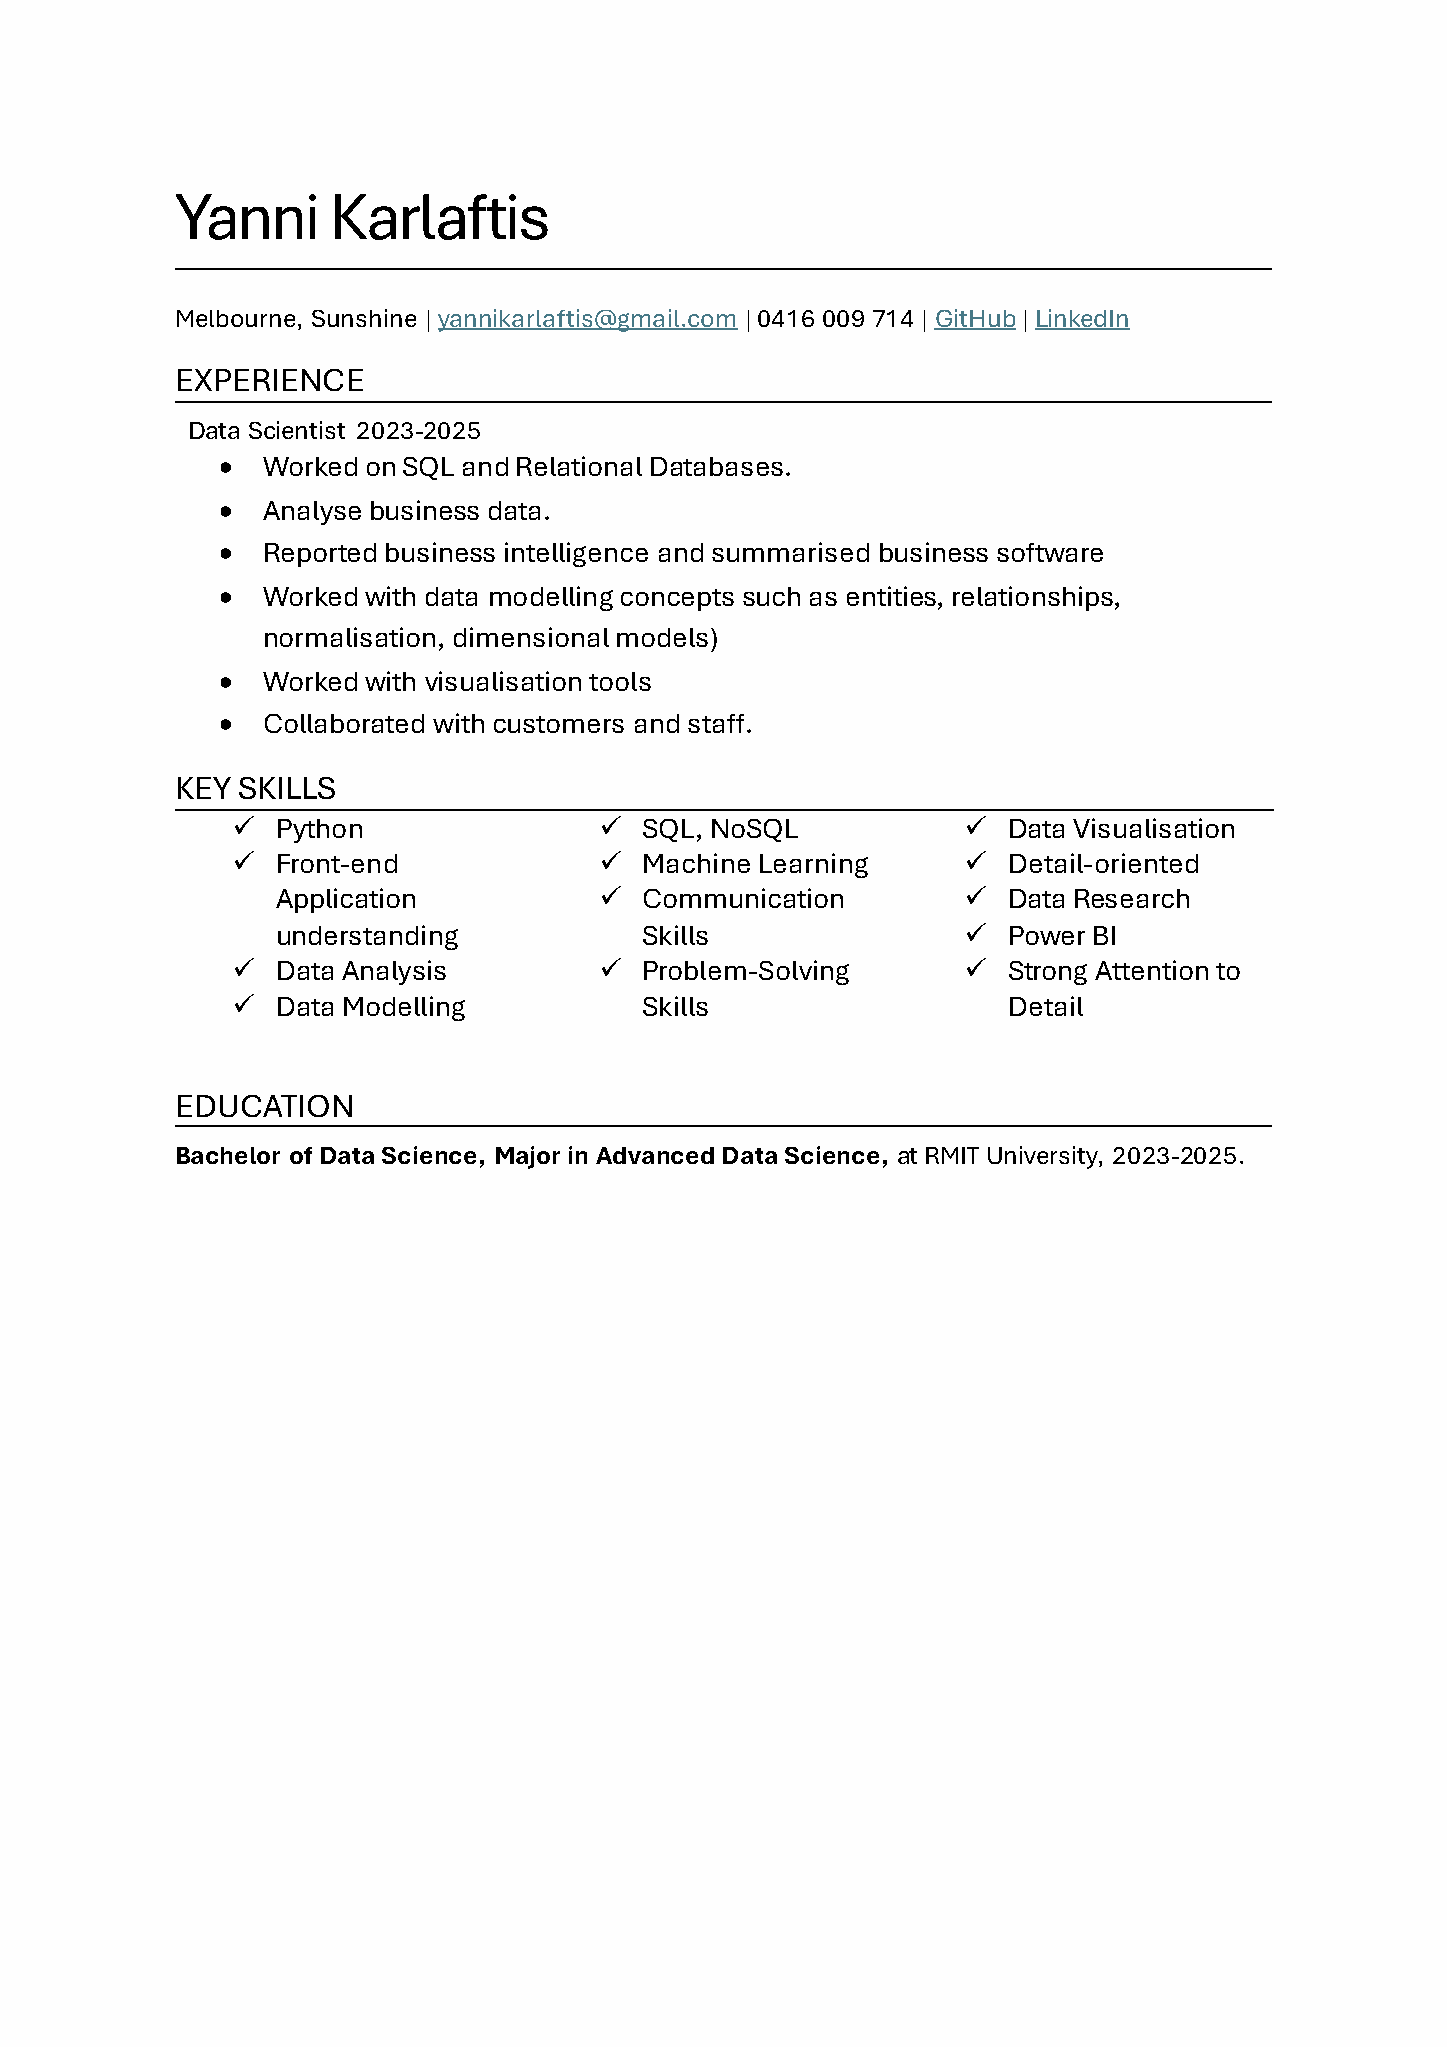

In [36]:
pages[0].to_image(resolution=175)

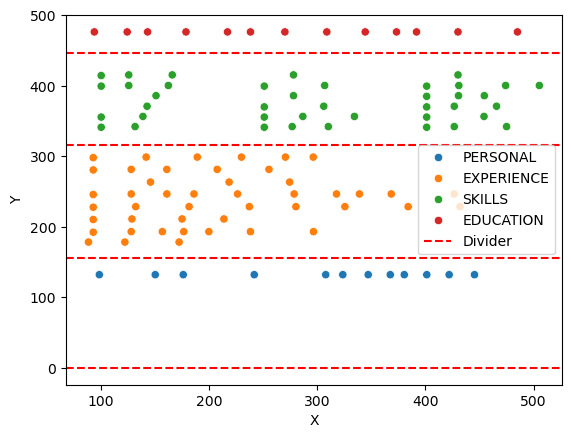

In [37]:
ax = sns.scatterplot(data=resume_df, x="X", y="Y", hue="cluster")

for i, y in enumerate(y_dividers):
    if i == 0:
        plt.axhline(y=y, color="r", linestyle="--", label="Divider")
    else:
        plt.axhline(y=y, color="r", linestyle="--")
        
for i, points in enumerate(x_dividers):
    x_pos = points[0]
    y_start = points[1]
    y_end = points[2]

    if y_start == float("inf"):
        y_start = plt.ylim()[1]

    if y_end == float("inf"):
        y_end = plt.ylim()[1]

    plt.vlines(x=x_pos, ymin=y_start, ymax=y_end, colors="r", linestyles="--")
        
ax.legend()
plt.show()

In [38]:
resume_df

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,left_distance,bottom_distance,right_distance,top_distance,fontname,fontsize,original_word,X,Y,cluster
2,0.306449,0.525905,-0.056477,-0.219811,0.426536,0.132020,-0.001994,-0.331740,0.107065,1.272440,...,72.0750,137.5456,124.9518,126.7456,44,10.8,"Melbourne,",98.5134,132.1456,PERSONAL
3,0.660050,0.481080,0.208010,-0.131810,-0.122400,-0.020926,-0.410020,0.460500,-0.257400,1.463400,...,128.4510,137.5456,171.9210,126.7456,44,10.8,Sunshine,150.1860,132.1456,PERSONAL
4,-0.349840,0.471390,0.333830,0.348820,-0.062755,-0.332640,0.208690,-0.266220,0.555550,0.482490,...,174.6210,137.5456,177.5370,126.7456,44,10.8,|,176.0790,132.1456,PERSONAL
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,180.1700,137.5456,303.2468,126.7456,44,10.8,yannikarlaftis@gmail.com,241.7084,132.1456,PERSONAL
6,-0.349840,0.471390,0.333830,0.348820,-0.062755,-0.332640,0.208690,-0.266220,0.555550,0.482490,...,306.3200,137.5456,309.2360,126.7456,44,10.8,|,307.7780,132.1456,PERSONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.221526,0.354466,0.034770,-0.082265,-0.009074,0.397500,-0.357798,-0.043230,-0.197937,2.279000,...,322.8820,481.5956,365.6932,470.7956,47,10.8,"Science,",344.2876,476.1956,EDUCATION
113,-0.367690,0.598210,0.132290,0.235060,-0.046757,0.363070,0.140990,-0.100930,-0.158770,2.537100,...,368.7700,481.5956,377.6584,470.7956,44,10.8,at,373.2142,476.1956,EDUCATION
114,1.149900,-0.212000,-0.092440,0.050635,-0.288780,-0.272450,0.114730,-0.188760,-0.329900,-1.427400,...,380.1424,481.5956,403.2976,470.7956,44,10.8,RMIT,391.7200,476.1956,EDUCATION
115,0.142769,0.226675,0.053690,-0.167552,0.155595,0.105450,-0.279998,-0.244965,-0.204500,2.571300,...,405.9004,481.5956,454.1688,470.7956,44,10.8,"University,",430.0346,476.1956,EDUCATION


In [39]:
resume_sections = segmentate(df=resume_df, clusters=combined_clusters)

In [40]:
resume_sections["SKILLS"] = sub_segmentate_skills(segmented_sections=resume_sections["SKILLS"])

#### Chunk and Classify Job Listing

In [42]:
filename = 'models/job_listing_vectorizer.joblib'

vectorizer = joblib.load(filename)

In [43]:
filename = 'models/job_listing_rf_classifier.joblib'

job_listing_tf_classifier = joblib.load(filename)

In [44]:
filename = 'models/job_listing_label_encoder.joblib'

job_listing_label_encoder = joblib.load(filename)

In [45]:
def chunk_text(text: str) -> list[str]: return re.split(r"[\n:;]|\.\s", text)

In [46]:
def clean_chunks(chunks: list[str]) -> list[str]:
    cleaned_chunks = []
    for chunk in chunks:
        chunk = chunk.strip()
        if chunk:
            cleaned_chunks.append(chunk)
        
    return cleaned_chunks

In [47]:
def vectorize_chunks(chunks: list[str], vectorizer: TfidfVectorizer()) -> pd.DataFrame:
    vectorized_chunks = vectorizer.transform([chunk for chunk in chunks])
    vectorized_chunks_df = pd.DataFrame(vectorized_chunks.toarray(), columns=vectorizer.get_feature_names_out())
    return vectorized_chunks_df

In [48]:
def classify_chunks(vectorized_chunks: pd.DataFrame, rf: RandomForestClassifier()) -> list[int]: return rf.predict(vectorized_chunks)

In [49]:
chunks = chunk_text(text=job_listing)

chunks = clean_chunks(chunks=chunks)

job_listing_vectorized_chunks_df = vectorize_chunks(chunks=chunks, 
                                                    vectorizer=vectorizer)

results = classify_chunks(vectorized_chunks=job_listing_vectorized_chunks_df, 
                          rf=job_listing_tf_classifier)

In [50]:
job_listing_sections = {"EDUCATION": [], "EXPERIENCE": [], "SKILLS":[], "RESPONSIBILITIES":[], "NOISE":[]}

decoded_labels = job_listing_label_encoder.inverse_transform(results.reshape(-1,1))
zipped_classified_chunks = zip(chunks, decoded_labels)

for i in zipped_classified_chunks:
    job_listing_sections[i[1][0]].append(i[0])

In [51]:
job_listing_sections

{'EDUCATION': ['Bachelor degree in Data Science'],
 'EXPERIENCE': ['Exposure to relational databases and SQL through study, projects, internships, or early work experience',
  'Data analysis, Data engineering, Data modelling experience',
  'Exposure in business intelligence or reporting & software development',
  'At least 2 years of experience'],
 'SKILLS': ['Basic understanding of how front‑end applications interact with back‑end databases or APIs',
  'Strong analytical and problem‑solving skills, with the ability to break down ambiguous problems',
  'Clear written communication skills and a detail‑oriented approach to documentation',
  'Familiarity with data modelling concepts (entities, relationships, normalisation, dimensional models)',
  'Reporting/visualisation tools (e.g., Power BI)'],
 'RESPONSIBILITIES': ['Analyse front‑end systems and workflows to understand how fields map to backend databases',
  'Contribute to logical and conceptual data models describing entities, relatio

In [52]:
resume_sections["EDUCATION"] = [resume_sections["EDUCATION"].strip()]
resume_sections["EXPERIENCE"] = [resume_sections["EXPERIENCE"].strip()]

#### Embed

In [54]:
from transformers import BertTokenizer
from transformers.models.bert.modeling_bert import BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

In [55]:
# Function to get BERT embeddings
def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=512
    )
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [56]:
# Generate embeddings for each segmentation
embedded_resume_sections = {}
for section, texts in resume_sections.items():
    embedded_resume_sections[section] = np.array([get_bert_embedding(text, tokenizer, model) 
                                           for text in texts]
    )

In [57]:
embedded_job_listing_sections = {}
for section, texts in job_listing_sections.items():
    embedded_job_listing_sections[section] = np.array([get_bert_embedding(text, tokenizer, model) 
                                           for text in texts]
    )

#### Compare Resume and Job Listing

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [60]:
def create_similarity_matrix(resume_embeddings: list, job_listing_embeddings: list):
    similarity_matrix = []
    for i in job_listing_embeddings:
        similarity_arr = []
        for j in resume_embeddings:
            similarity_arr.append(cosine_similarity([i], [j])[0][0])
        similarity_matrix.append(similarity_arr)
    return similarity_matrix

In [61]:
def best_match_aggregation(similarity_matrix: list) -> (float, float):
    best_matches = [max(arr) for arr in similarity_matrix]
    aggregated_final_score = sum(best_matches) / len(best_matches)
    return aggregated_final_score, best_matches

In [62]:
def compare_resume_and_job_listing(resume_embeddings: list, job_listing_embeddings: list, report: bool=True) -> float:
    ##---EXPERIENCE---##
    experience_matrix = create_similarity_matrix(resume_embeddings["EXPERIENCE"], job_listing_embeddings["EXPERIENCE"])
    aggregated_experience_final_score, best_experience_matches = best_match_aggregation(experience_matrix)
    if report == True:
        print("##---EXPERIENCE---##")
        print(f"Total: {aggregated_experience_final_score}")
        print(f"Overall: {best_experience_matches}")
        print("\n")

    ##---EDUCATION---##
    education_matrix = create_similarity_matrix(resume_embeddings["EDUCATION"], job_listing_embeddings["EDUCATION"])
    aggregated_education_final_score, best_education_matches = best_match_aggregation(education_matrix)
    if report == True:
        print("##---EDUCATION---##")
        print(f"Total: {aggregated_education_final_score}")
        print(f"Overall: {best_education_matches}")
        print("\n")

    ##---SKILLS---##
    skills_matrix = create_similarity_matrix(resume_embeddings["SKILLS"], job_listing_embeddings["SKILLS"])
    aggregated_skills_final_score, best_skills_matches = best_match_aggregation(skills_matrix)
    if report == True:
        print("##---SKILLS---##")
        print(f"Total: {aggregated_skills_final_score}")
        print(f"Overall: {best_skills_matches}")
        print("\n")

    overall_similarity = (aggregated_skills_final_score + aggregated_education_final_score + aggregated_experience_final_score) / 3
    if report == True:
        print("##---RESULT---##")
        print(f"Total Similarity: {overall_similarity}")
    
    return overall_similarity

In [63]:
overall_similarity = compare_resume_and_job_listing(resume_embeddings=embedded_resume_sections,
                                                   job_listing_embeddings=embedded_job_listing_sections)

##---EXPERIENCE---##
Total: 0.6453058421611786
Overall: [0.71349645, 0.71928805, 0.7449614, 0.4034775]


##---EDUCATION---##
Total: 0.7110087871551514
Overall: [0.7110088]


##---SKILLS---##
Total: 0.7452396273612976
Overall: [0.8045919, 0.7485436, 0.75660247, 0.6853281, 0.73113203]


##---RESULT---##
Total Similarity: 0.7005180855592092


In [64]:
resume_sections

{'EDUCATION': ['Bachelor of Data Science, Major in Advanced Data Science, at RMIT University, 2023-2025.'],
 'EXPERIENCE': ['Data Scientist 2023-2025 • Worked on SQL and Relational Databases. • Analyse business data. • Reported business intelligence and summarised business software • Worked with data modelling concepts such as entities, relationships, normalisation, dimensional models) • Worked with visualisation tools • Collaborated with customers and staff.'],
 'SKILLS': ['',
  'Python',
  'Front-end Application understanding',
  'Data Analysis',
  'Data Modelling',
  'SQL, NoSQL',
  'Machine Learning',
  'Communication Skills',
  'Problem-Solving Skills',
  'Data Visualisation',
  'Detail-oriented',
  'Data Research',
  'Power BI',
  'Strong Attention to Detail'],
 'PERSONAL': 'Melbourne, Sunshine | yannikarlaftis@gmail.com | 0416 009 714 | GitHub | LinkedIn ',
 'UNKOWN': ''}